In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
pd.set_option("display.max_rows", 20)

In [2]:
df = pd.read_csv('cleaned_city_temperature.csv')

In [3]:
df

Region  Country                  City  Month  Day  Year  \
0               Africa  Algeria               Algiers      1    1  1995   
1               Africa  Algeria               Algiers      1    2  1995   
2               Africa  Algeria               Algiers      1    3  1995   
3               Africa  Algeria               Algiers      1    4  1995   
4               Africa  Algeria               Algiers      1    5  1995   
...                ...      ...                   ...    ...  ...   ...   
2767759  North America       US  San Juan Puerto Rico      7   27  2013   
2767760  North America       US  San Juan Puerto Rico      7   28  2013   
2767761  North America       US  San Juan Puerto Rico      7   29  2013   
2767762  North America       US  San Juan Puerto Rico      7   30  2013   
2767763  North America       US  San Juan Puerto Rico      7   31  2013   

         AvgTemperature        Date  
0             17.888889  1995-01-01  
1              9.666667  1995-01-02  
2              9.333333  1995-01-03  
3              8.000000  1995-01-04  
4              8.833333  1995-01-05  
...                 ...         ...  
2767759       28.000000  2013-07-27  
2767760       27.555556  2013-07-28  
2767761       29.000000  2013-07-29  
2767762       28.777778  2013-07-30  
2767763       28.666667  2013-07-31  

[2767764 rows x 8 columns]

In [4]:
print(f"Year           : min: {df['Year'].min()}, max {df['Year'].max()}")
print(f"Month          : min: {df['Month'].min()}, max {df['Month'].max()}")
print(f"Day            : min: {df['Day'].min()}, max {df['Day'].max()}")
print(f"AvgTemperature : min: {df['AvgTemperature'].min()}, max {df['AvgTemperature'].max()}")

Year           : min: 1995, max 2019
Month          : min: 1, max 12
Day            : min: 1, max 31
AvgTemperature : min: -45.55555555555556, max 43.333333333333336


Visualization and analysis of data

In [5]:
data1 = df.sort_values(by = ['AvgTemperature'], ascending  = False).head(1)
data2 = df.sort_values(by = ['AvgTemperature'], ascending = True).head(1)
hl_data = pd.concat([data1, data2])
hl_data.index = ['Highest', 'Lowest']
hl_data

Region Country       City  Month  Day  Year  AvgTemperature  \
Highest    Middle East  Kuwait     Kuwait      8    1  2012       43.333333   
Lowest   North America      US  Fairbanks     12   31  1999      -45.555556   

               Date  
Highest  2012-08-01  
Lowest   1999-12-31

In [6]:
# global yearly stats:
# - average, min, max temperature per year 
# - date and location (city/country/region) of lowest temperature during this year
# - date and location (city/country/region) of highest temperature during this year
dfg = (df.groupby('Year')['AvgTemperature'].agg(['mean','min','idxmin','max','idxmax']).reset_index()
       .merge(df[['Region','Country','City','Date']], left_on='idxmin',right_index=True)
       .merge(df[['Region','Country','City','Date']], left_on='idxmax',right_index=True,suffixes=('_min','_max')) )

# top hottest/coldest cities over the entire period
dft = df.groupby(['Country','City'])['AvgTemperature'].mean().sort_values(ascending=False).reset_index()

fig = make_subplots(rows=2,cols=2,
                    column_widths=[0.5, 0.5],row_heights=[0.5, 0.5],
                    vertical_spacing=0.15,
                    specs=[[{"type": "scatter", "colspan": 2},None],
                           [  {"type": "bar"}, {"type": "bar"}]],
                    subplot_titles=['Global temperatures over the years 1995 to 2019','Top 5 hottest cities','Top 5 coldest cities'],
                    y_title='Average temperature °C')

# global temperature trend graph
trace = (px.scatter(dfg, x='Year', y='mean',trendline='ols',trendline_color_override='red')
         .add_trace(px.line(dfg, x='Year', y='mean').data[0])
         .update_traces(hovertemplate='<b>%{x}</b><br><i>Avg temp :<b> %{y}</b></i><br>%{text}',
                        text = ['Min temp : <b>'+str(d['min'])+'</b>, country : '+d['Country_min']+', city : '+d['City_min']+', date : '+str(d['Date_min'])[:10] +'<br>'+'Max temp : <b>'+str(d['max'])+'</b>, country : '+d['Country_max']+', city : '+d['City_max']+', date :'+str(d['Date_max'])[:10]
                                for _, d in dfg.iterrows()],
                        hoverlabel_bgcolor='white')).data

fig.add_trace(trace[0], row=1, col=1)
fig.add_trace(trace[1], row=1, col=1)
fig.add_trace(trace[2], row=1, col=1)

# hottest cities graph
fig.add_trace((px.bar(dft.head(5),
                      x='City',
                      y='AvgTemperature',
                      color='AvgTemperature',
                      color_continuous_scale=['darkorange','red'],
                      hover_data=['Country', 'AvgTemperature'],
                      opacity=0.8)).data[0],
              row=2, col=1)

# coldest cities graph
fig.add_trace((px.bar(dft.tail(5),
                      x='City',
                      y='AvgTemperature',
                      color='AvgTemperature',
                      color_continuous_scale=['blue','lightblue'],
                      hover_data=['Country', 'AvgTemperature'],
                      title='Top 5 coldest cities',
                      opacity=0.8)).data[0],
              row=2, col=2)

fig.update_layout(height=600, margin=dict(r=10, t=40, b=50, l=60))
fig.update_layout(coloraxis_autocolorscale=False, coloraxis_colorscale=['blue','lightblue','yellow','orange','darkorange','red'],coloraxis_colorbar_title='Temp °C')

In [7]:
# temperature stats, grouped by country and year
dfc = (df.groupby(['Year','Country'])['AvgTemperature'].agg(['mean']).reset_index()
      .rename(columns={'mean': 'AvgTemperature'})
      .sort_values(by=['Year','Country']))
dfc['Hottest'] = dfc.groupby(by=['Year'])['AvgTemperature'].rank(method="min",ascending=False)
dfc['Coldest'] = dfc.groupby(by=['Year'])['AvgTemperature'].rank(method="min",ascending=True)
dfc

Year     Country  AvgTemperature  Hottest  Coldest
0     1995     Algeria       18.005816     67.0     53.0
1     1995   Argentina       16.500761     73.0     47.0
2     1995   Australia       16.389863     74.0     46.0
3     1995     Austria       10.139574    100.0     20.0
4     1995     Bahamas       25.061661     37.0     83.0
...    ...         ...             ...      ...      ...
2951  2019     Uruguay       16.772361     64.0     46.0
2952  2019  Uzbekistan       16.667595     65.0     45.0
2953  2019   Venezuela       26.564841     29.0     81.0
2954  2019     Vietnam       25.127979     36.0     74.0
2955  2019  Yugoslavia       13.875116     76.0     34.0

[2956 rows x 5 columns]

In [8]:
px.choropleth(data_frame=dfc,
              locations="Country",
              locationmode='country names',
              animation_frame="Year",
              color='AvgTemperature',
              color_continuous_scale = 'Portland',
              height=600,
              title="Average temperature of countries over the years 1995 to 2019")

In [9]:
# animation speed
step_duration=800

fig = make_subplots(rows=2,cols=2,
                    shared_xaxes=False,shared_yaxes=False,
                    column_widths=[0.5,0.5],row_heights=[0.2, 0.8],
                    horizontal_spacing=0.05,vertical_spacing=0.1,
                    specs=[[{"type": "table"},{"type": "table"}],[{"type": "bar"},{"type": "bar"}]],
                    subplot_titles=[None,None,'Top coldest countries','Top hottest countries'],
                    y_title='Average temperature °C')

dfg_t=dfg[dfg['Year']==1995]

# graph for the lowest temperature day
fig.add_trace(go.Table(header=dict(values=list(['<b>' + 'Lowest temperature' + '</b>','','']),
                                   align="left",
                                   line_color='white',
                                   fill_color='white'),
                       cells=dict(values=['<b>' + dfg_t['min'].map(u"{:,.2f}".format) + '</b>', dfg_t['Date_min'],dfg_t['City_min']+', '+dfg_t['Country_min']],
                                  align = "left",
                                  line_color='white',
                                  fill_color='white')),
              row=1, col=1)

# graph for the highest temperature day
fig.add_trace(go.Table(header=dict(values=list(['<b>' + 'Highest temperature' + '</b>','','']),
                                   align="left",
                                   line_color='white',
                                   fill_color='white'),
                       cells=dict(values=['<b>' + dfg_t['max'].map(u"{:,.2f}".format) + '</b>', dfg_t['Date_max'], dfg_t['City_max']+', '+dfg_t['Country_max']],
                                  align = "left",
                                  line_color='white',
                                  fill_color='white')),row=1, col=2)

# top coldest countries graph
fig.add_trace((px.bar(data_frame=dfc[dfc['Coldest']<=5].sort_values(['Year','Coldest']),
                      x='Country',
                      y='AvgTemperature',
                      color='AvgTemperature',
                      text='AvgTemperature',
                      hover_data={'Year':False},
                      animation_frame='Year',
                      opacity=0.8).update_layout(coloraxis_colorbar_title='Temp °C',
                                                 title_text='Top coldest countries',
                                                 title_x=0.5)
               .update_xaxes(title_text=None)
               .update_yaxes(title_text='Average temperature °C', range=[-4,33])
               .update_traces(texttemplate='%{text:.2f}')).data[0],row=2, col=1)

# top hottest countries graph
fig.add_trace((px.bar(data_frame=dfc[dfc['Hottest']<=5].sort_values(['Year','Hottest']),
                      x='Country',
                      y='AvgTemperature',
                      color='AvgTemperature',
                      text='AvgTemperature',
                      hover_data={'Year':False},
                      animation_frame='Year',
                      opacity=0.8).update_layout(coloraxis_colorbar_title='Temp °C',
                                                 title_text='Top hottest countries',
                                                 title_x=0.5)
               .update_xaxes(title_text=None)
               .update_yaxes(title_text='Average temperature °C', range=[-4,33])     
               .update_traces(texttemplate='%{text:.2f}')).data[0],row=2, col=2)

# animation frames
years = list(dfc['Year'].sort_values().unique())
frames=[]
for year in years: 
    dfg_t=dfg[dfg['Year']==year]
    dfc_c=dfc[(dfc['Coldest']<=5)&(dfc['Year']==year)].sort_values(['Year','Coldest'])
    dfc_h=dfc[(dfc['Hottest']<=5)&(dfc['Year']==year)].sort_values(['Year','Hottest'])
    
    frames.append(go.Frame(name=str(year),
                           data=[go.Table(cells=dict(values=['<b>' + dfg_t['min'].map(u"{:,.2f}".format) + '</b>', dfg_t['Date_min'], dfg_t['City_min']+', '+dfg_t['Country_min']])),
                                 go.Table(cells=dict(values=['<b>' + dfg_t['max'].map(u"{:,.2f}".format) + '</b>', dfg_t['Date_max'], dfg_t['City_max']+', '+dfg_t['Country_max']])),
                                 go.Bar(x=dfc_c['Country'], y=dfc_c['AvgTemperature'], text=dfc_c['AvgTemperature']),
                                 go.Bar(x=dfc_h['Country'], y=dfc_h['AvgTemperature'], text=dfc_h['AvgTemperature'])],
                           traces=[0,1,2,3]))
    
fig.frames=frames

# buttons Play and Pause
buttons = [dict(label='Play',
                method='animate',
                args=[[f'{year}' for year in years[1:]],
                      dict(frame=dict(duration=step_duration, easing='linear', redraw=True),
                           fromcurrent=True,
                           transition=dict(duration=0, easing='linear'))]),
           dict(label='Pause',
                method='animate',
                args=[[None],dict(frame=dict(duration=0, redraw=False),
                                  mode='immediate',
                                  transition=dict(duration=0))])]

# let's add buttons to the layout
updatemenus=[dict(type='buttons',
                  direction='left', 
                  y=0,
                  x=-0.1,
                  xanchor='left',
                  yanchor='top',
                  pad=dict(b=10, t=45),
                  buttons=buttons)]

# yearly slider
sliders= [dict(yanchor='top',
               xanchor='left',
               currentvalue=dict(prefix='Year: ', visible=True, xanchor='left'),
               transition=dict(duration=0, easing='linear'),
               pad=dict(b=10, t=25),
               len=0.9, x=0.1, y=0 ,
               steps=[dict(args=[[year],
                                 dict(frame=dict(duration=step_duration, easing='linear', redraw=True),
                                      transition=dict(duration=0, easing='linear'))],
                           label= str(year), method='animate')
                      for year in years])]

fig.update_layout(updatemenus=updatemenus, sliders=sliders)
fig.update_layout(height=600,margin=dict(r=10, t=30, b=50, l=10))
fig.update_layout(coloraxis_autocolorscale=False, coloraxis_colorscale=['blue','lightblue','yellow','orange','darkorange','red'],coloraxis_colorbar_title='Temp °C')
fig.update_yaxes(range=[-4, 33], autorange=False, row=2, col=1)

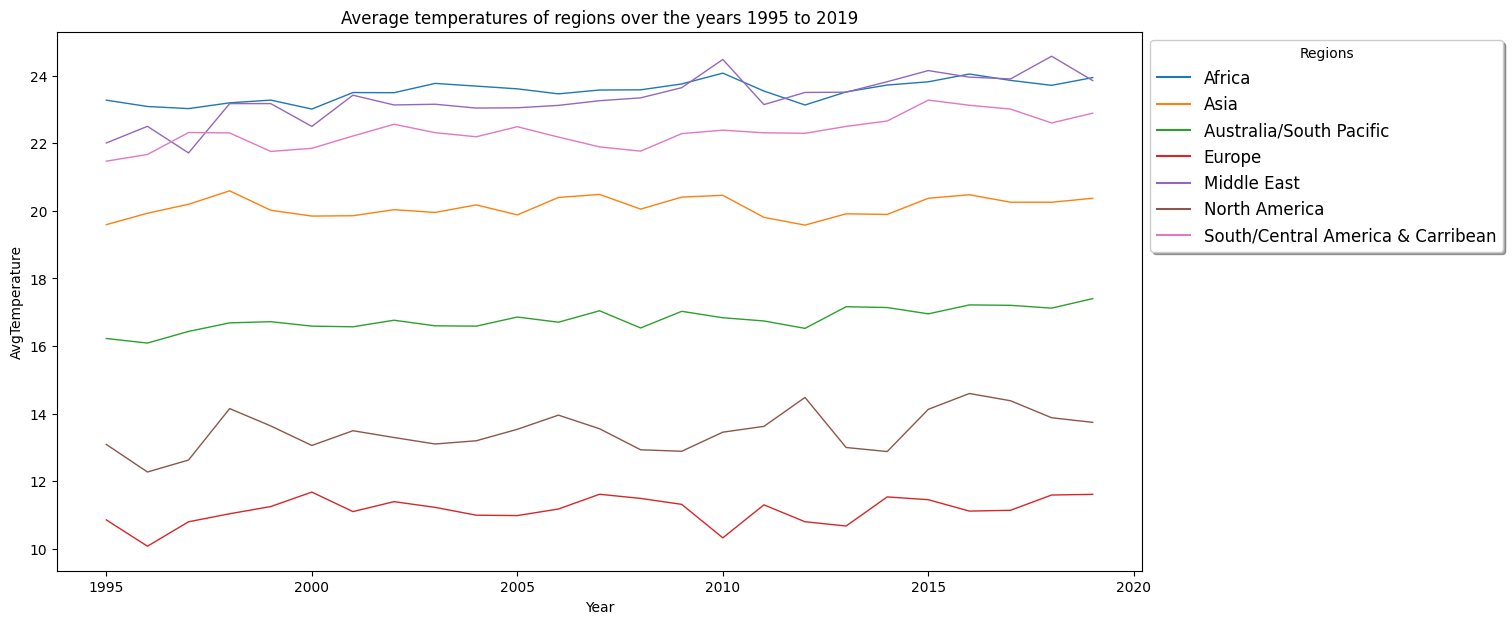

In [10]:
region = df[['Region', 'Year', 'AvgTemperature']].groupby(['Region', 'Year']).mean()
plt.figure(figsize = (14, 7))
plt.title('Average temperatures of regions over the years 1995 to 2019')
sns.lineplot(x = 'Year', y = 'AvgTemperature', hue = 'Region', units = 'Region', markers = True, dashes = False, estimator = None, lw = 1, data = region)
plt.legend(bbox_to_anchor = (1, 1), shadow = True, fontsize = 'large', title = 'Regions')
plt.show()

In [11]:
# several mappings for seasonality charts
month_dict = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"June" ,7:"July", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
season_dict = {1:"Winter", 2:"Spring", 3:"Summer", 4:"Autumn"}
season_month_map = {1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1}

# temperature stats, grouped by year, month, region and country 
dfmc = (df.groupby(['Year','Month','Region','Country'])['AvgTemperature'].agg(['mean']).reset_index()
        .rename(columns={'mean': 'AvgTemperature','Month': 'Month_num'})
        .sort_values(by=['Year','Month_num','Region','Country']))

dfmc['Season_num'] = dfmc['Month_num'].map(season_month_map)
dfmc['Season'] = dfmc['Season_num'].map(season_dict)
dfmc['Month'] = dfmc['Month_num'].map(month_dict)

# temperature stats, grouped by year, season, month and region 
dfmr = (dfmc.groupby(['Year','Season_num','Season','Month_num','Month','Region'])['AvgTemperature'].agg(['mean']).reset_index()
        .rename(columns={'mean': 'AvgTemperature'})
        .sort_values(by=['Year','Month_num','Region']))

# temperature stats, grouped by month and region 
dfmr_g = (dfmr.groupby(['Region','Month_num','Month'])['AvgTemperature'].agg(['mean']).reset_index()
          .rename(columns={'mean': 'AvgTemperature'})
          .sort_values(by=['Region','Month_num']))

In [12]:
px.bar(dfmr_g,
       x='Month', y='AvgTemperature',
       facet_col='Region',
       facet_col_wrap=4,
       facet_row_spacing=0.1,
       color='Region',
       hover_name='Region',
       hover_data={'Region':False,'AvgTemperature':':.2f'},
       height=450,
       width=800).update_traces(showlegend=False).update_layout(title_text='Average temperature per region and month, °C',
               title_x=0.25,
               margin=dict(l=0,r=5)).update_xaxes(tickangle=45).update_yaxes(title_text=None).for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

In [13]:
dfyc = dfmc.groupby(['Country','Year'])['AvgTemperature'].mean().reset_index()
dfycs = dfmc.groupby(['Country','Year','Season_num','Season'])['AvgTemperature'].mean().reset_index()

# add new "period" dimension: 1995-2014 (first 15 years) and 2015-2019 (last 5 years) 
dfmc['Period'] = '1995-2014'
dfmc['Period'].loc[dfmc['Year']>2014] = '2015-2019'

fig = make_subplots(rows=4,cols=4,
                    row_heights=[0.25, 0.25, 0.15, 0.35],
                    vertical_spacing=0.1,horizontal_spacing=0.02,
                    shared_yaxes=True,
                    specs=[[{"type": "scatter", "colspan": 4},None,None,None],
                           [{"type": "scatter"},{"type": "scatter"},{"type": "scatter"},{"type": "scatter"}],
                           [{"type": "histogram", "colspan": 4},None,None,None],
                           [{"type": "histogram", "colspan": 4},None,None,None]],
                    subplot_titles=['Average temperature dynamics on country level (1995-2019)',
                                    'winter','spring','summer','autumn',
                                    'Temperature distribution dynamics: (1995-2014) vs (2015-2019)',None])

# average temperature dynamics on country level (1995-2019) subplot
# initially all subplots output information for the first country in the list of countries (=dfyc['Country'].head(1))
fig.add_trace((px.line(data_frame = dfyc[dfyc['Country']==dfyc['Country'].head(1).squeeze()],
                       x='Year',y='AvgTemperature')).data[0],row=1, col=1)


# seasonal dynamics subplots
traces_seasonal = (px.line(data_frame = dfycs[dfycs['Country']==dfyc['Country'].head(1).squeeze()],
                           x='Year',y='AvgTemperature',
                           facet_col='Season',
                           color='Season',
                           color_discrete_sequence=['blue','green','red','orange']).update_traces(showlegend=False)
                   .for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1],textangle=0))).data
for i, trace in enumerate(traces_seasonal):
    fig.add_trace(trace, row=2, col=i+1)

    
# temperature distribution dynamics: (1995-2014) vs (2015-2019) subplot   
traces_dist = (px.histogram(dfmc[dfmc['Country']==dfyc['Country'].head(1).squeeze()],
                            x='AvgTemperature',
                            histnorm='probability density',
                            color='Period',
                            barmode='overlay',
                            marginal='box',
                            nbins=25).update_traces(showlegend=False)
               .for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1],textangle=0))).data

fig.add_trace(traces_dist[0], row=4, col=1)
fig.add_trace(traces_dist[1], row=3, col=1)
fig.add_trace(traces_dist[2], row=4, col=1)
fig.add_trace(traces_dist[3], row=3, col=1)

buttons = []
# populate frames in all subplots for each country in the dropdown list
for country in dfyc['Country'].sort_values().unique():
    # average temperature dynamics on country level subplot
    dfyc_c = dfyc[dfyc['Country']==country]
    args_x=[dfyc_c['Year']]
    args_y=[dfyc_c['AvgTemperature']]
    args_f=[0]
    # seasonal subplots
    for i in range(len(traces_seasonal)):
        dfycs_c = dfycs[(dfycs['Country']==country)&(dfycs['Season_num']==i+1)]
        args_x.append(dfycs_c['Year'])
        args_y.append(dfycs_c['AvgTemperature'])
        args_f.append(i+1)
    # temperature distribution dynamics subplot
    period_num = len(dfmc['Period'].sort_values().unique())
    frames_num = round(len(traces_dist)/period_num)
    k = 0
    for j, period in enumerate(dfmc['Period'].sort_values().unique()):
        for i in range(frames_num):   
            dfmc_c = dfmc[(dfmc['Country']==country)&(dfmc['Period']==period)]
            args_x.append(dfmc_c['AvgTemperature'])
            args_y.append(None)
            args_f.append(len(traces_seasonal)+k+1) 
            k += 1
    
    buttons.append(dict(method='restyle',
                        label=country,
                        visible=True,
                        args=[{'x': args_x,'y':args_y}, args_f]))    


# update layout menu with our country drill down box and country frames
updatemenu=[dict(buttons=buttons,
                 direction='down',
                 pad={'r': 10, 't': 10},
                 showactive=True,
                 x=-0.05,
                 xanchor='left',
                 y=1.1,
                 yanchor='top')] 
                              
fig.data[0].line.dash='dash'
fig.data[0].mode ='markers+lines' 
fig.data[0].line.color='#00CC96' 
fig.update_layout(font_size=10)
fig.for_each_annotation(lambda a: a.update(font=dict(size=14)))
fig.layout.annotations[0].font.size=16
fig.layout.annotations[-1].font.size=16
fig.update_xaxes(range=[1995, 2019], autorange=False, row=1)
fig.update_xaxes(range=[1995, 2019], autorange=False, row=2) 
fig.update_xaxes(showticklabels=False, row=3)
fig.update_yaxes(showticklabels=False, row=3)

fig.update_traces(showlegend=True, selector=dict(type='histogram'))
fig.update_layout( updatemenus=updatemenu,
                  height=600,
                  barmode='overlay',
                  margin=dict(r=10, t=20, b=30, l=0),
                  legend=dict(orientation='h',
                              yanchor='top',
                              y=0.33,
                              xanchor='left',
                              x=-0.05))

del dfyc_c, dfycs_c, dfmc_c, dfyc, dfycs
gc.collect()
fig.show()

In [14]:
#top hottest/coldest cities over the entire period
dft = df.groupby(['Region','Country','Year'])['AvgTemperature'].mean().sort_values(ascending=False).reset_index()
dft=dft.sort_values(by=['Country','Year'])
dft.to_csv('top_temp.csv', index=False)

In [15]:
dfc2 = (df.groupby(['Region','Year','Country'])['AvgTemperature'].agg(['mean']).reset_index()
      .rename(columns={'mean': 'AvgTemperature'})
      .sort_values(by=['Year','Country']))

last_dft = dfc2.drop_duplicates(subset='Country', keep="last")
last_dft=last_dft.sort_values(by=['Country','Year']).reset_index(drop=True)


first_dft = dfc2.drop_duplicates(subset='Country', keep="first")
first_dft=first_dft.sort_values(by=['Country','Year']).reset_index(drop=True)

last_dft = last_dft.rename(columns={"AvgTemperature": "AvgNew"}).drop(['Year'], axis=1)
first_dft = first_dft.rename(columns={"AvgTemperature": "AvgLast"}).drop(['Year', 'Region', 'Country'], axis=1)



dfc2 = pd.concat([last_dft, first_dft], axis=1)
dfc2['difference'] = dfc2["AvgNew"] - dfc2["AvgLast"]


In [16]:
# global yearly stats:
# - average, min, max temperature per year 
# - date and location (city/country/region) of lowest temperature during this year
# - date and location (city/country/region) of highest temperature during this year

dfc2 = dfc2.sort_values(by=['difference'], ascending=False)

# hottest cities graph
table = px.bar(dfc2.head(20),
                      x='Country',
                      y='difference',
                      color='difference',
                      color_continuous_scale=['blue','red'],
                      hover_data=['Country', 'difference'],
                      opacity=0.8)

table.show()

table2 = px.bar(dfc2.tail(20),
                      x='Country',
                      y='difference',
                      color='difference',
                      color_continuous_scale=['blue','red'],
                      hover_data=['Country', 'difference'],
                      opacity=0.8)

table2.show()

In [17]:
#There is some missing value in first 4 countries, so it looks like this countries has highest temperature rises. 
#But its not true. We examined those countries, these countries are not critical countries. So we ignore these countries.
dfc2= dfc2.iloc[4:]
dfc2.reset_index().to_csv('top_temp_diff.csv', index=False)